In [1]:
import geopandas as gp
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from meteostat import Stations

sns.set_style('whitegrid')

import matplotlib.pyplot as plt

# Data plots

In [2]:
#data = pd.read_csv('./data/soep/CSV/pl.csv', usecols=['syear', 'plb0108'])
#data.rename(columns={'syear':'year'}, inplace=True)
#data[data < 0] = np.nan
#temp = data.groupby('year', as_index=False)['plb0108'].apply(lambda x: x.isna().sum() / x.shape[0])
#temp.rename(columns={'plb0108':'P(missing|year)'}, inplace=True)
#fig, ax = plt.subplots(figsize=(8.3, 4))
#sns.barplot(temp, x='year', y='P(missing|year)', ax=ax, color='blue')
#ax.set_xticklabels(temp['year'], rotation = 90)
#plt.savefig(f'./prod/plots/missing_data.pdf', dpi=300)

# Weather data plots


In [3]:
# nuts3 data + centroids
nuts = gp.read_file('./data/geo/nuts5000/5000_NUTS1.shp')
nuts.to_crs(crs='EPSG:4326', inplace=True)
nuts.drop(columns=['NUTS_LEVEL', 'NUTS_NAME'], inplace=True)

# Get nuts codes from name
nuts['wnuts1'] = nuts['NUTS_CODE']

# Convert codes used in SOEP
names1 = pd.read_csv('./data/geo/lookup_nuts1.csv')
nuts.set_index('wnuts1', inplace=True)
names1.set_index('wnuts1', inplace=True)
nuts = nuts.join(names1, how='left')
nuts.reset_index(inplace=True)

nuts.drop(columns=['wnuts1'], inplace=True)

In [4]:
# station data
query = Stations()
stations = query.fetch()
stations.reset_index(inplace=True)
points_station = stations.loc[stations['country'] == 'DE', ['latitude', 'longitude']]

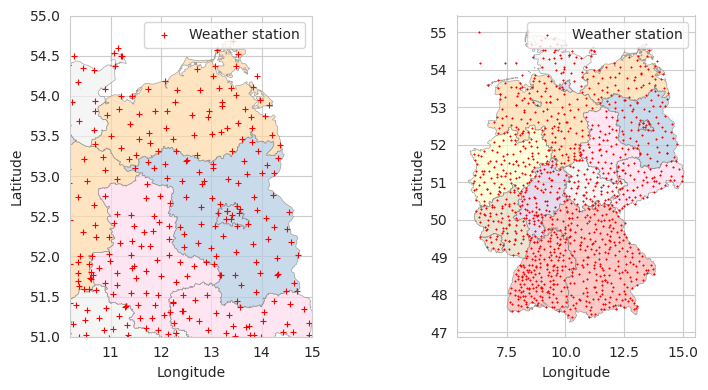

In [5]:
# Get centroids
nuts['c'] = nuts.geometry.to_crs('+proj=cea').centroid.to_crs('EPSG:4326')
points = nuts['c']
xs, ys = points.x, points.y

# Set up the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(8.2, 4), gridspec_kw={'height_ratios': [1]})

# Plot the zoomed-in view on the left subplot
axs[0].set_xlim(10.2, 15)  # Adjust the x-axis limits for the zoomed-in view
axs[0].set_ylim(51, 55)  # Adjust the y-axis limits for the zoomed-in view
nuts['geometry'].plot(ax=axs[0], cmap='Pastel1', linewidth=0.5, edgecolor='gray', alpha=0.7)
axs[0].scatter(points_station['longitude'], points_station['latitude'], color="red", marker='+', s=15, linewidths=0.8, label='Weather station')

# Plot the full view on the right subplot
nuts['geometry'].plot(ax=axs[1], cmap='Pastel1', linewidth=0.5, edgecolor='gray', alpha=0.7)
axs[1].scatter(points_station['longitude'], points_station['latitude'], color="red", marker='+', s=1, linewidths=0.8, label='Weather station')

# Set common labels for both subplots
for ax in axs:
    ax.legend()
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

fig.tight_layout()
plt.savefig('./prod/plots/stations.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
weather = pd.read_parquet('./data/weather/7D.parquet.gzip', columns='prcp tsun wspd pres snow tavg tmin tmax nuts1'.split())
weather

,prcp,tsun,wspd,pres,snow,tavg,tmin,tmax,nuts1
0,4.721711,69.807692,13.181579,1009.500000,129.934211,-5.419737,-8.407237,-2.203289,1.0
1,3.919474,70.615385,11.426316,1010.182353,152.105263,-6.783158,-10.114737,-3.681053,1.0
2,3.274561,98.461538,10.157895,1010.682353,164.473684,-8.081140,-11.447807,-4.693421,1.0
3,2.807143,108.065934,9.525564,1010.757143,171.390977,-9.220301,-12.586842,-5.754511,1.0
4,1.830827,144.527473,7.486466,1011.785714,197.030075,-11.681203,-14.850000,-7.664662,1.0
...,...,...,...,...,...,...,...,...,...
223438,4.310757,200.976190,19.453468,1009.392434,0.779221,8.436222,5.362084,11.669339,16.0
223439,4.121316,215.119048,20.031108,1010.560136,1.753247,7.502061,4.482580,10.610333,16.0
223440,4.130632,178.404762,19.380176,1011.555788,2.538961,6.917589,3.866431,10.135799,16.0
223441,4.497713,198.708333,19.235455,1011.806719,2.538961,6.785291,3.632270,10.256917,16.0


In [7]:
print(weather.describe().transpose().drop(columns='count'))

              mean         std         min          25%          50%  \
prcp      1.970474    1.869754    0.000000     0.551648     1.489796   
tsun    273.552068  184.331148    0.000000   119.325603   243.394286   
wspd     13.207285    5.387343    0.000000     9.706501    12.060000   
pres   1015.775236    7.086116  979.557143  1011.491833  1015.828571   
snow      5.991644   23.122792    0.000000     0.000000     0.000000   
tavg      9.614114    6.932107  -16.180952     4.356973     9.571429   
tmin      5.570594    6.021624  -20.138245     1.272953     5.484416   
tmax     13.777619    8.071110  -12.416667     7.323423    13.960140   
nuts1     8.500436    4.609562    1.000000     5.000000     9.000000   

               75%          max  
prcp      2.850549    21.057143  
tsun    396.942857   928.285714  
wspd     15.294699    73.300000  
pres   1019.996480  1042.373469  
snow      0.036630   408.701299  
tavg     15.415467    29.514286  
tmin     10.640113    23.200000  
tmax   

In [8]:
variables = pd.read_csv('./data/variables_edited2.csv')
print(variables.drop(columns=['relative']).to_latex(float_format='.1f', index=False))

\begin{tabular}{llll}
\toprule
  variable &                                     variable\_label &       type &                    category \\
\midrule
       pid &                    Unveraenderliche Personennummer &    Nominal &                         key \\
       hid &                           Aktuelle Haushaltsnummer &    Nominal &                         key \\
       cid &                  Case ID, Ursprungshaushaltsnummer &    Nominal &                         key \\
       pnr &                                Lfd. Personennummer &    Nominal &                         key \\
     syear &                         Erhebungsjahr (SurveyYear) &   Discrete &                       Other \\
pla0009\_v2 &                             Geschlecht [1984-2019] &    Nominal &     Demographic Information \\
   plb0018 &                      Bezahlte Arbeit letzte 7 Tage &    Nominal &             Economic Status \\
plb0019\_v2 &                Mutterschutz/Elternzeit [2001-2020] &    Nominal 

# Performance

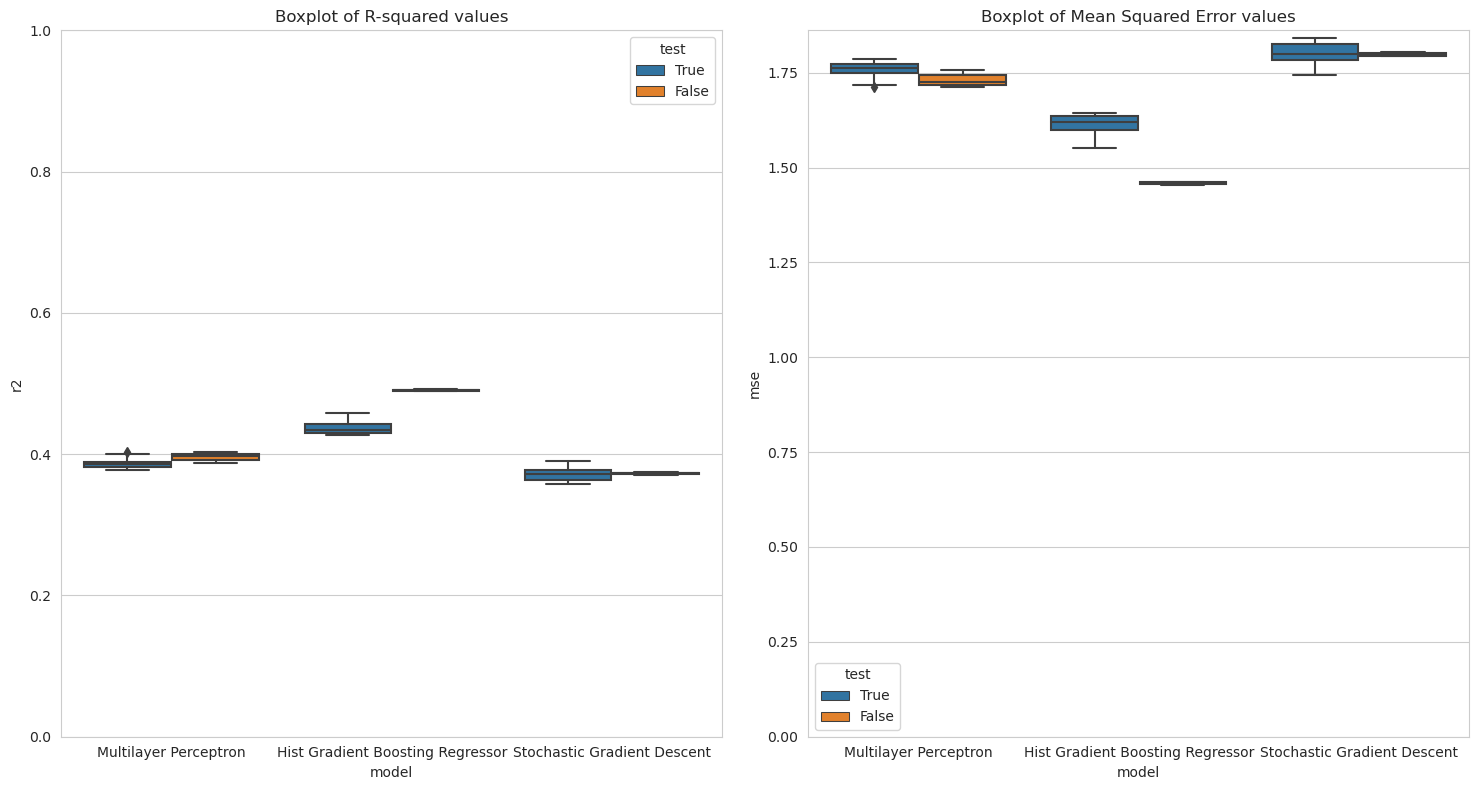

In [9]:
base_path = './prod/pca'

data = pd.read_csv(f'{base_path}/tables/score_results.csv')

# Convert 'test' column to string type
data['test'] = data['test'].astype(str)

# Setup the figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(6, 4.5))

# Boxplot for R-squared values
sns.boxplot(x='model', y='r2', hue='test', data=data, ax=axs[0])
axs[0].set_title('Boxplot of R-squared values')
axs[0].set_ylim([0, 1])  # Set y-axis to start at 0

# Modify legend for the first subplot
legend0 = axs[0].legend()
legend0.set_title('Data Split')
legend0.texts[0].set_text('Train')
legend0.texts[1].set_text('Test')

# Boxplot for Mean Squared Error values
sns.boxplot(x='model', y='mse', hue='test', data=data, ax=axs[1])
axs[1].set_title('Boxplot of Mean Squared Error values')
axs[1].set_ylim(bottom=0)  # Set y-axis to start at 0

# Modify legend for the second subplot
legend1 = axs[1].legend()
legend1.set_title('Data Split')
legend1.texts[0].set_text('Train')
legend1.texts[1].set_text('Test')

plt.tight_layout()
plt.savefig(f'{base_path}/plots/model_performance.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Variable importance

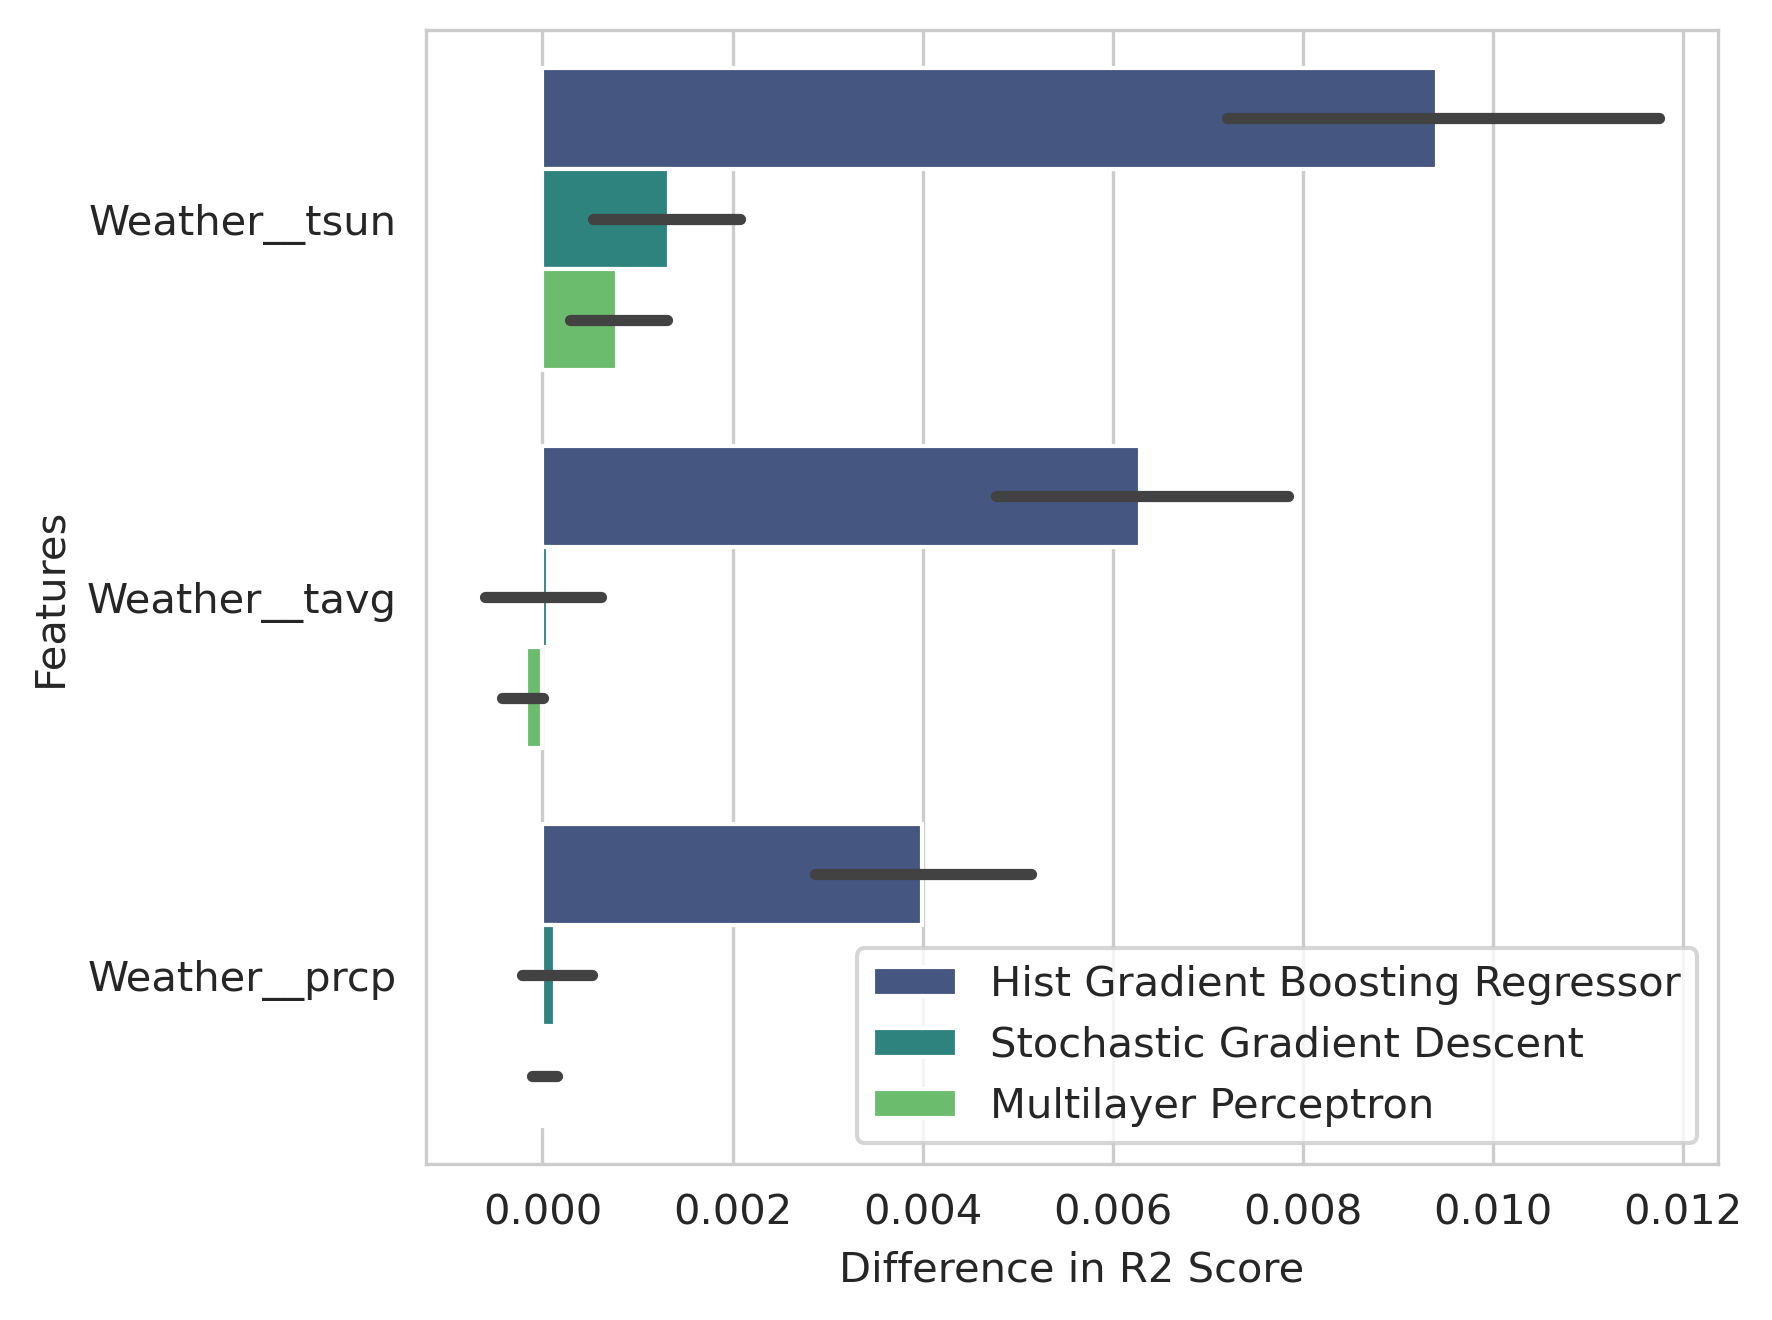

In [20]:
base_path = './prod/pca2'
cutoff = 0

# Load the new data
importance_df = pd.read_csv(f"{base_path}/tables/importance_results.csv")

# Aggregate permutation importance scores across all cross-validation folds for each feature and model
filtered_importance = importance_df.groupby(['features', 'model']).mean().reset_index().\
                            groupby('features').\
                            filter(lambda x: np.sum(x['importance_mean'] >= cutoff) >= 2).\
                            reset_index()

# Sorting features by their mean importance
selected_features = filtered_importance['features'].unique()
importance_df = importance_df[importance_df['features'].isin(selected_features)]
sorted_importance_data = importance_df.sort_values(by='importance_mean', ascending=False)

# Visualizing the importance of features across different models
fig, ax = plt.subplots(figsize=(6, 4.5), dpi=300)
sns.barplot(x='importance_mean', y='features', hue='model', data=sorted_importance_data, palette='viridis')
ax.set_xlabel('Difference in R2 Score')
ax.set_ylabel('Features')
ax.legend()
plt.tight_layout()
plt.savefig(f'{base_path}/plots/feature_importance.pdf', dpi=300)

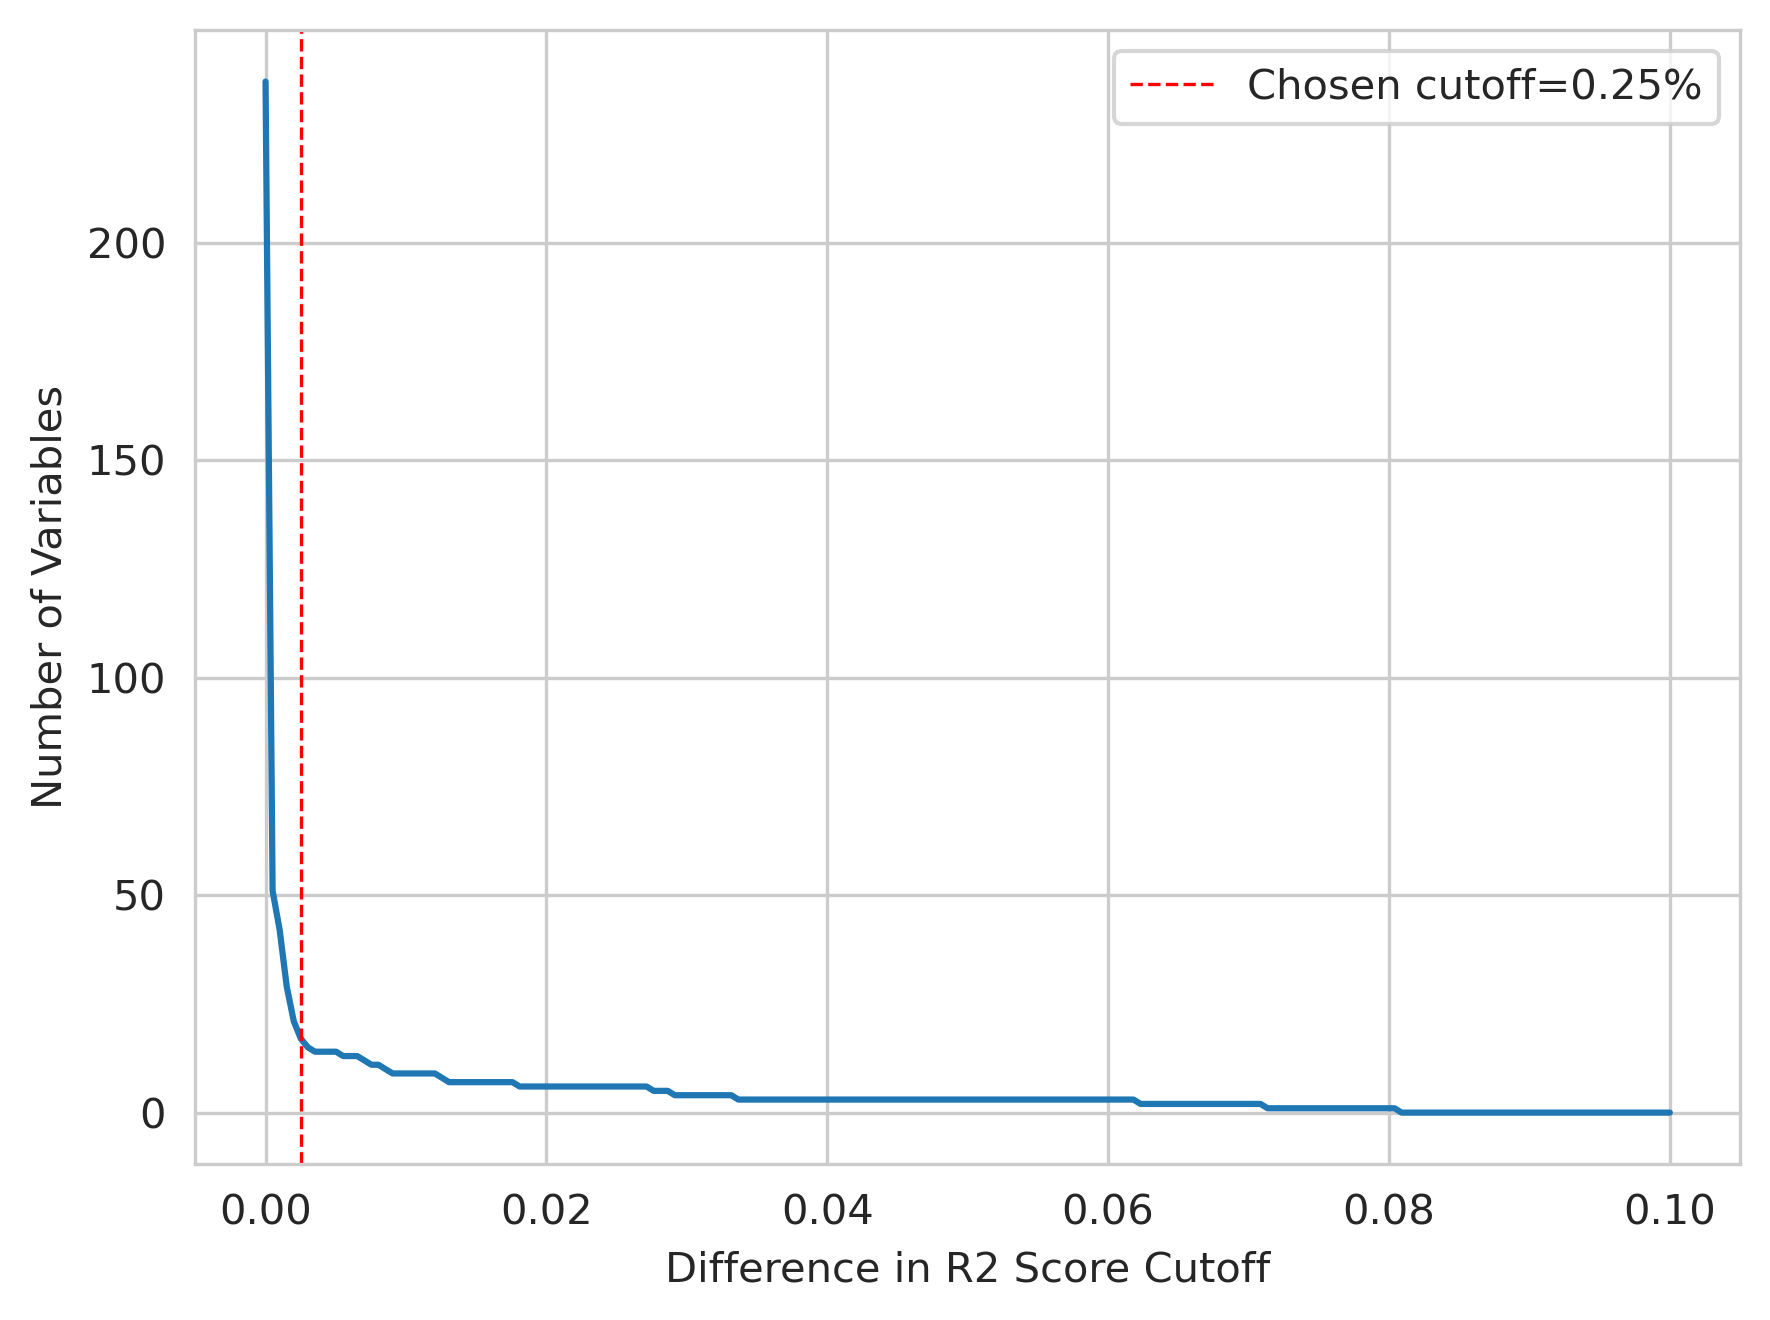

In [14]:
base_path = './prod/all'
cutoff = 0.0025


# Load the new data
importance_df = pd.read_csv(f"{base_path}/tables/importance_results.csv")

x_values = np.linspace(0, 0.1, 200)
y_values = np.zeros_like(x_values)

for i, val in enumerate(x_values):
    # Aggregate permutation importance scores across all cross-validation folds for each feature and model
    y_values[i] = importance_df.groupby(['features', 'model']).mean().reset_index().\
                                groupby('features').\
                                filter(lambda x: np.sum(x['importance_mean'] >= val) >= 2).\
                                reset_index()['features'].unique().__len__()

fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), dpi=300)
ax.plot(x_values, y_values)
ax.set_ylabel('Number of Variables')
ax.set_xlabel('Permutation Importance Cutoff')
#ax.set_xticks(x_values[::5], [f'{x*100:.1f}%' if i%2==0 else '' for i,x in enumerate(x_values[::5])])
ax.axvline(x = cutoff, color = 'red', ls='--', lw=0.8, label=f'Chosen cutoff={cutoff*100}%')
ax.legend()

plt.tight_layout()
plt.savefig(f'{base_path}/plots/feature_importance_cutoff.pdf', dpi=300)